# Introduction

![](https://raw.githubusercontent.com/avatar101/R_metric_forecasting/main/Capture2.PNG)

**AIM:**

1. To forecast R metric
2. Learn how to set up ML experiment
2. Compare different model architecture
3. **Not** a comparison between ML and conventional methods

# Data prep

* R-metric
* V @ 250hPa
* T2M 

for an example grid-point, Berlin. 

10-years of 6-hourly ERA-I dataset (2000-2010) due to limitations of the cloud server

## Imports

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xarray as xr

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
sns.set(style='whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install netcdf4

     |████████████████████████████████| 4.3MB 2.6MB/s 
     |████████████████████████████████| 296kB 31.8MB/s 


In [ ]:
R_metric=xr.open_dataset('/content/drive/My Drive/PhD/data/R_metric_Nhov_35deg_65deg_1979_2018.nc')
t2m = xr.open_dataset('/content/drive/My Drive/PhD/data/T2M_40N60N_0E20E_1979_2017.nc')
v250 = xr.open_dataset('/content/drive/My Drive/PhD/data/V250_40N60N_0E20E_1979_2018.nc')

In [ ]:
# selecting grid point for Berlin 52N, 13 E
df = t2m.sel(lat=52., 
             lon=13., time=slice('2000-01-01',
                                 '2010-12-31'))\
                                 .to_dataframe().drop(columns=['lat',
                                                               'lon']
                                                      )
df['V'] = v250.sel(lat=52.,
                   lon=13.,
                   time=slice('2000-01-01',
                   '2010-12-31')).\
                   to_dataframe().drop(columns=['lat', 'lon', 'lev'])

df['R_metric'] = R_metric.R_metric.sel(lon=13.,
                                       time=slice('2000-01-01',
                                                  '2010-12-31'))\
                                                  .to_dataframe().\
                                                  drop(columns=['lon',
                                                                'lev']
                                                       )
                                                  
df['T2M'] = df['T2M'] - 273.15 # converting to celsius
                                                


In [ ]:
df.head(10)

,T2M,V,R_metric,Day sin,Day cos,Year sin
time,,,,,,
2000-01-01 00:00:00,-1.15,-50.677109,6.479398,-5.461913e-12,1.000000e+00,-0.004731
2000-01-01 06:00:00,-0.15,-33.808769,6.172855,1.000000e+00,8.025257e-12,-0.000430
2000-01-01 12:00:00,1.85,-22.487400,6.100472,1.058860e-11,-1.000000e+00,0.003871
2000-01-01 18:00:00,1.85,-25.060698,6.061133,-1.000000e+00,1.399970e-12,0.008171
2000-01-02 00:00:00,3.85,-28.837570,5.915867,-1.163374e-12,1.000000e+00,0.012472
2000-01-02 06:00:00,2.85,-25.334900,5.719277,1.000000e+00,3.726719e-12,0.016772
2000-01-02 12:00:00,3.85,-20.078175,5.539949,6.290063e-12,-1.000000e+00,0.021072
2000-01-02 18:00:00,2.85,-34.485260,5.565670,-1.000000e+00,-8.853407e-12,0.025371
2000-01-03 00:00:00,2.85,-24.549431,5.657986,3.135164e-12,1.000000e+00,0.029670


## First look

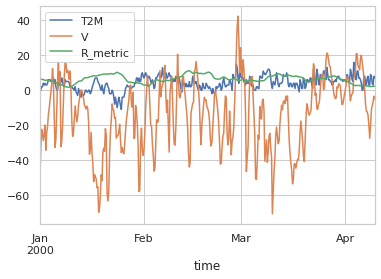

In [ ]:
df[:400].plot()

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
T2M,16072.0,10.026518,8.283682,-19.150000,3.850000,9.850000,15.850000,35.850000
V,16072.0,-3.161847,17.964548,-77.683105,-13.863235,-1.918257,8.820037,55.243164
R_metric,16072.0,6.469540,3.543076,0.058801,3.792926,6.029698,8.725004,22.353352


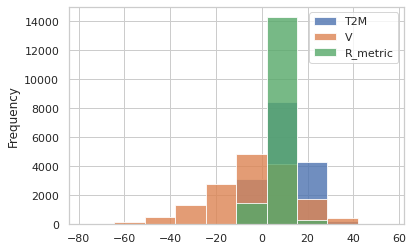

In [ ]:
df.plot( kind='hist', alpha=0.8)

In [ ]:
date_time = pd.to_datetime(df.index, format='%Y-%m-%D %H:%M:%S') # converting to datetime

# maps values of a series into another series
timestamp_s = date_time.map(datetime.datetime.timestamp) 
timestamp_s.values # in seconds

array([9.4668480e+08, 9.4670640e+08, 9.4672800e+08, ..., 1.2937752e+09,
       1.2937968e+09, 1.2938184e+09])

In [ ]:
# converting time into a sine and cosine signal
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

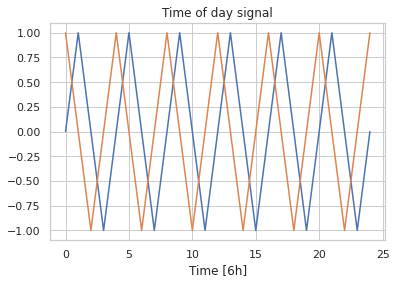

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [6h]')
plt.title('Time of day signal')

In [ ]:
df = df.reset_index()
df['month'] = df.time.dt.month

# winter=0...autumn=3
df.loc[:, 'season'] = 0
for mons, label in zip([[3,4,5], [6,7,8], [9,10,11]], [1,2,3]):
  df.loc[df.month.isin(mons), 'season'] = label

In [ ]:
df.tail()

,time,T2M,V,R_metric,Day sin,Day cos,Year sin,month,season
16067,2010-12-30 18:00:00,-6.15,-27.812326,9.049332,-1.000000e+00,-8.792300e-12,-0.020513,12,0
16068,2010-12-31 00:00:00,-4.15,-24.362413,9.183405,-1.135564e-11,1.000000e+00,-0.016213,12,0
16069,2010-12-31 06:00:00,-0.15,-30.368053,9.287132,1.000000e+00,-6.329264e-13,-0.011913,12,0
16070,2010-12-31 12:00:00,1.85,-33.494812,9.293676,1.930418e-12,-1.000000e+00,-0.007612,12,0
16071,2010-12-31 18:00:00,0.85,-31.225679,9.137352,-1.000000e+00,-4.493762e-12,-0.003312,12,0


## Which frequencies are important?

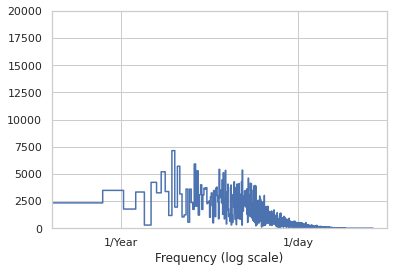

In [ ]:
fft = tf.signal.rfft(df['R_metric'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['R_metric'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 20000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

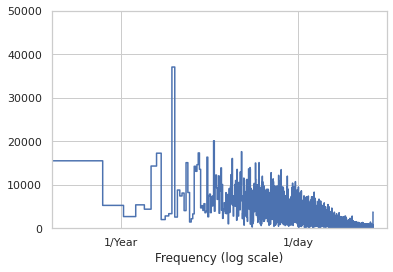

In [ ]:
fft = tf.signal.rfft(df['V'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['R_metric'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 50000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

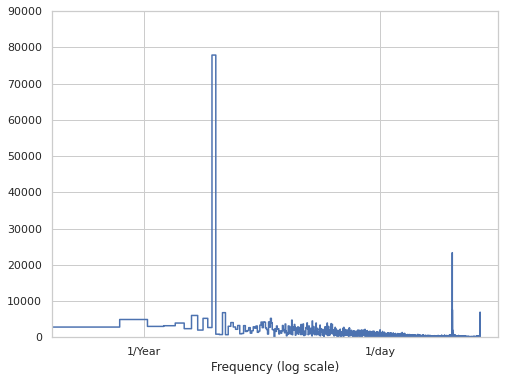

In [ ]:
fft = tf.signal.rfft(df['T2M'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['R_metric'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 90000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

Removing year column as the frequencies aren't important.

Adding monthly frequency

In [ ]:
month=12 * day # seconds

df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
df.head()

,time,T2M,V,R_metric,Day sin,Day cos,Year sin,month,season,Month sin,Month cos
0,2000-01-01 00:00:00,-1.15,-50.677109,6.479398,-5.461913e-12,1.000000e+00,-0.004731,1,0,0.500000,0.866025
1,2000-01-01 06:00:00,-0.15,-33.808769,6.172855,1.000000e+00,8.025257e-12,-0.000430,1,0,0.608761,0.793353
2,2000-01-01 12:00:00,1.85,-22.487400,6.100472,1.058860e-11,-1.000000e+00,0.003871,1,0,0.707107,0.707107
3,2000-01-01 18:00:00,1.85,-25.060698,6.061133,-1.000000e+00,1.399970e-12,0.008171,1,0,0.793353,0.608761
4,2000-01-02 00:00:00,3.85,-28.837570,5.915867,-1.163374e-12,1.000000e+00,0.012472,1,0,0.866025,0.500000


# Split the data

Using a (70%, 20%, 10%) split for training, validation and test sets. Random shuffling of the data is not relevant for our example.

In [ ]:
df = df.drop(columns=['time'])

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

num_features

10

## Normalize the data

Using a simple normalization scheme for simplicity

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

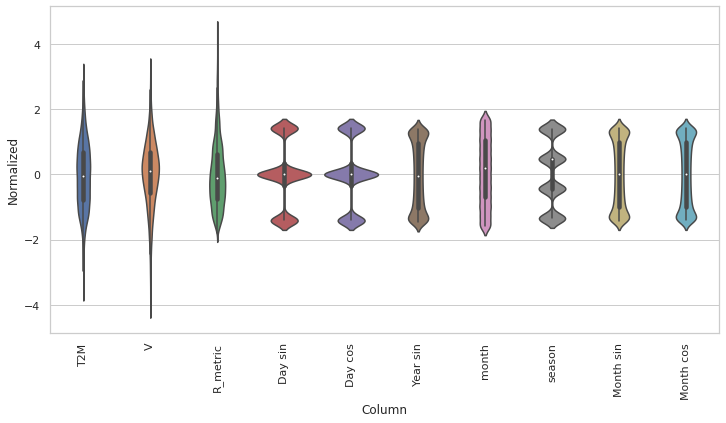

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data Windowing

We will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

*    The width (no. of time steps) of the input and label windows.
*    The time offset b/w them
*    Which features are used as `inputs`, `labels`, or `both`.

### Example windowing

1. A model that makes a prediction 1 time-step into the future, given 6 input time-steps of history would need a window like this:

  ![One prediction 1h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Figure out the label column indices.
    ## Save column names as dict with an integer label
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Figure out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift  # this length is being forecasted

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width # index where label starts
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    # Note Function to split input data hasn't been added yet

  def __repr__(self):
    """"Prints objects information, useful for debugging"""
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['R_metric'])
w1 # will print the __repr__

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['R_metric']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['R_metric'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['R_metric']

##2. Split window

Adding a function to our class to split the dataset into windows of inputs and labels.

![The initial window is all consecuitive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [ ]:
def split_window(self, features):
  """Converts input series into a window of inputs and a window of labels"""
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out

In [ ]:
# Stack three slices, the length of the total window:
# example_window is 3 batch of 7 time-steps for the 10 features(variables)

example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

# features is basically number of columns (variables) in df_train

All shapes are: (batch, time, features)
Window shape: (3, 7, 10)
Inputs shape: (3, 6, 10)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the WindowGenerator was initialized with label_columns=['T (degC)']. Initially this tutorial will build models that predict single output labels.


##3. Plot

Plot methods that allows a simple visualization of the split window:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='R_metric', max_subplots=3):

  """Allows simple visualization of the split window
  It aligns inputs, labels and (later) predictions based on the time that the
  item refers to
  """
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time (6h)')

WindowGenerator.plot = plot

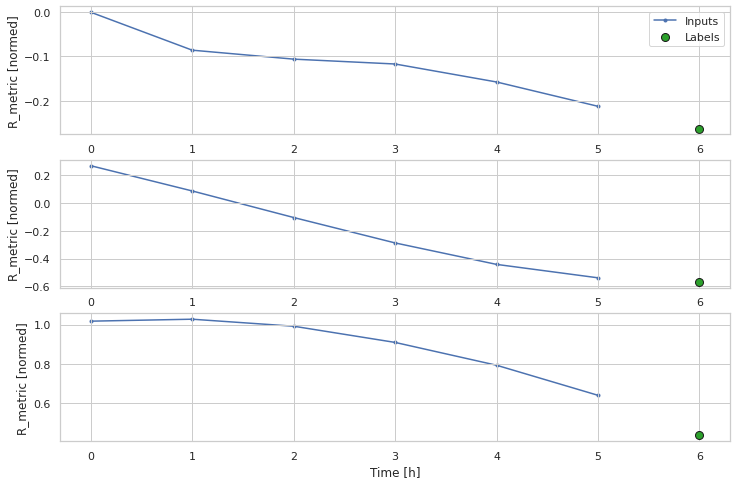

In [ ]:
w2.plot()

###4. Create `tf.data.Dataset` S

Finally this will take time series dataframe and convert it to a tensorflow dataset of (input_window, label_window) pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [ ]:
def make_dataset(self, data):
  """
  Finally this will take time series dataframe and convert it to a tensorflow
  dataset of (input_window, label_window) pairs using the 
  `preprocessing.timeseries_dataset_from_array` function.
  """
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,) # batch size is not the number of time-steps

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset  

The `WindowGenerator` object holds training, validation and test data. We will add properties for acessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting.

In [ ]:
# adding properties for accesing train, validation and test dataset from 
# Window Generator and a standard example batch for easy access and plotting 
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example 

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec
# None will determine batch size

(TensorSpec(shape=(None, 6, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 10)
Labels shape (batch, time, features): (32, 1, 1)


# Single step forecasting

## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the `T (degC)` value 1h into the future.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['R_metric'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['R_metric']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 10)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature. 

**So start with a model that just returns the current input as the prediction, predicting "No change"**. This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [ ]:
# Single-step input and single-step prediction model as a baseline
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['R_metric'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

101/101 [==============================] - 0s 3ms/step - loss: 0.0060 - mean_absolute_error: 0.0623


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['R_metric'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['R_metric']

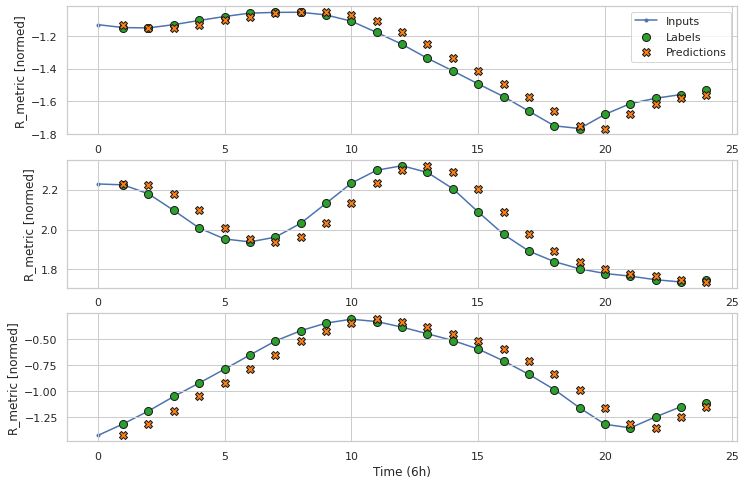

In [ ]:
wide_window.plot(baseline)

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 10)
Output shape: (32, 1, 1)


In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  """
  Function for training procedure
  """
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

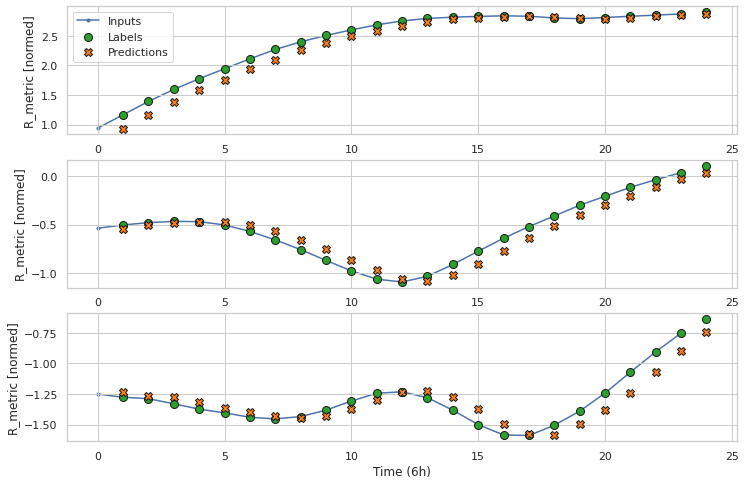

In [ ]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to interpret. You can pull out the layer's weights, and see the weight assigned to each input:

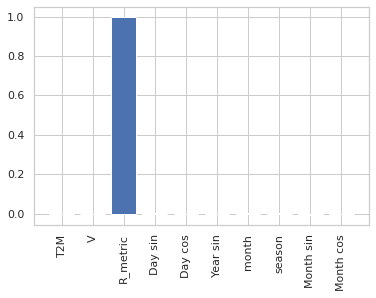

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Model places most weight on R_metric which is how it should be

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the **model will take multiple time steps as input to produce a single output**.

Create a `WindowGenerator` that will produce batches of the 3 steps of inputs and, 1 step of labels:


In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['R_metric'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['R_metric']

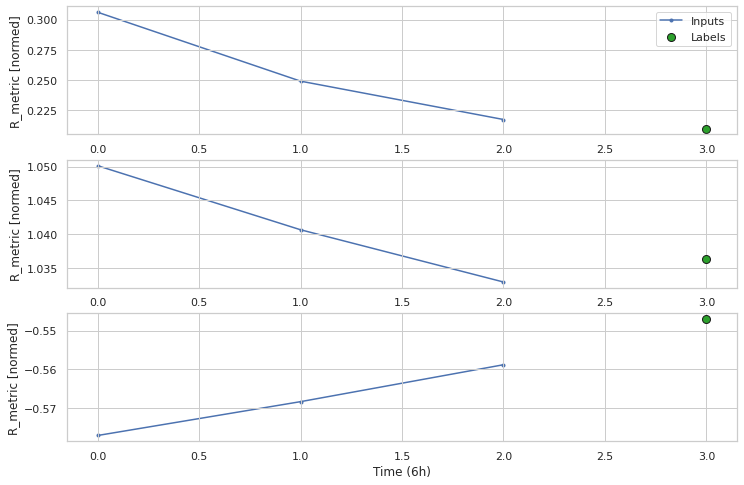

In [ ]:
# given 3 time-steps of the past, predict 1 time step into the future
conv_window.plot()

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 10)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

101/101 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0358


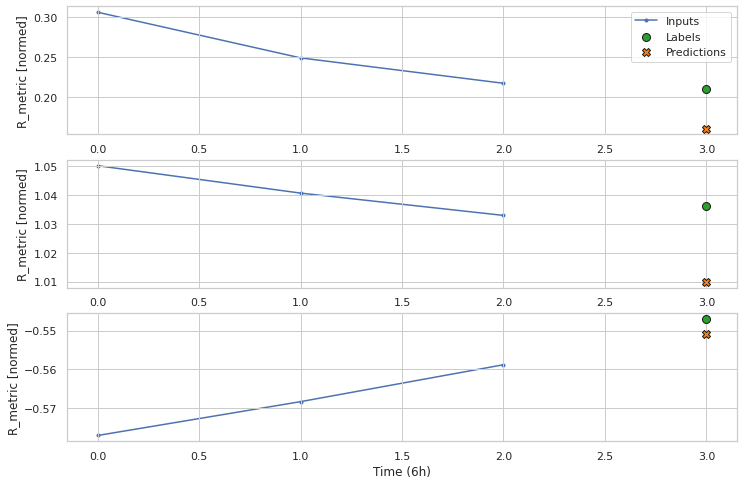

In [ ]:
conv_window.plot(multi_step_dense)

****

The main **down-side** of this approach is that the resulting model can only be executed on input wndows of exactly this shape. 

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 10)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,240], In[1]: [30,32] [Op:MatMul]


The convolutional models in the next section fix this problem.

### Convolution neural network
![](https://raw.githubusercontent.com/avatar101/R_metric_forecasting/main/Capture.PNG)

#### More Info 
A convolution layer (`layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `layers.Flatten` and the first `layers.Dense` are replaced by a `layers.Conv1D`.
* The `layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

#### Example window

The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

If you run it on wider input, it produces wider output:

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 10)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

101/101 [==============================] - 0s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0390


In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 10)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['R_metric'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['R_metric']

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 10)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


#### Example plot

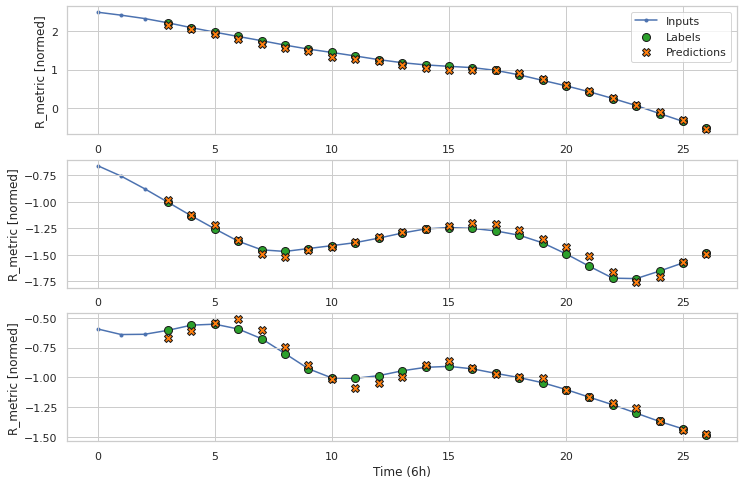

In [ ]:
wide_conv_window.plot(conv_model)

### Recurrent neural netowrk



![](https://raw.githubusercontent.com/avatar101/R_metric_forecasting/main/RNN.PNG)

We will use an RNN layer called `Long Short Term Memory (LSTM)`.
![](https://raw.githubusercontent.com/avatar101/R_metric_forecasting/main/LSTM.PNG)

#### More info


An important constructor argument for all keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways.

1. If `False`, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction: 

![An lstm warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True` the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple timesteps simultaneously.

![An lstm making a prediction after every timestep](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
# with return_sequences=True, model can be trained on multiple hours of data at
# a time

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 10)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

100/100 [==============================] - 0s 5ms/step - loss: 7.4789e-04 - mean_absolute_error: 0.0177


#### Example plot

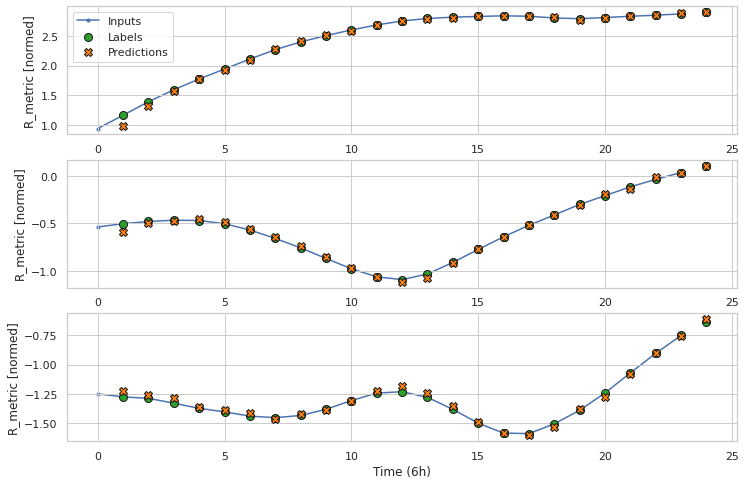

In [ ]:
wide_window.plot(lstm_model)

### Performance

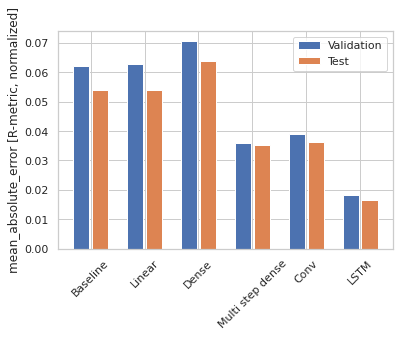

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [R-metric, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

**LSTM** outperforms rest of the models

## Multi-output models

Predicting multiple features is also possible just by changing the number of units in the output layer and adjusting the training window to include all features in the `labels`.



# Multi-step forecasting

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.

2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.


In [ ]:
OUT_STEPS = 24  # 24 time-steps is 6 days
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS, label_columns=['R_metric'],
                               shift=OUT_STEPS)
# shift can be used to predict even further ahead in the future

multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['R_metric']

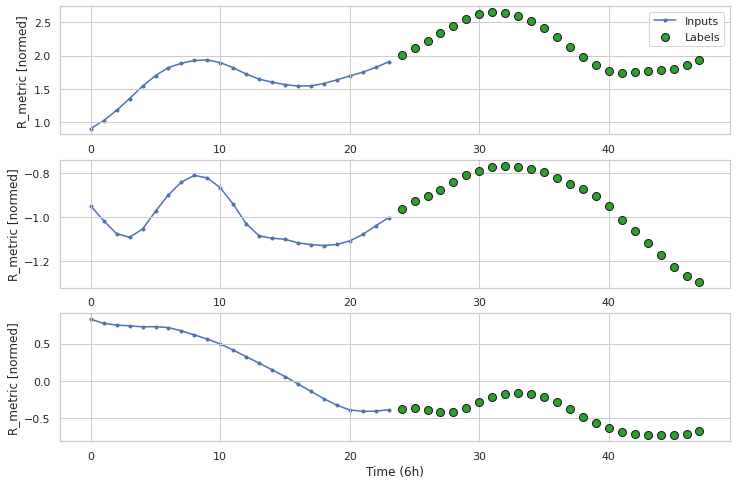

In [ ]:
multi_window.plot()

Creating a baseline for our multi-day forecast model

99/99 [==============================] - 0s 3ms/step - loss: 2.0200 - mean_absolute_error: 1.1215


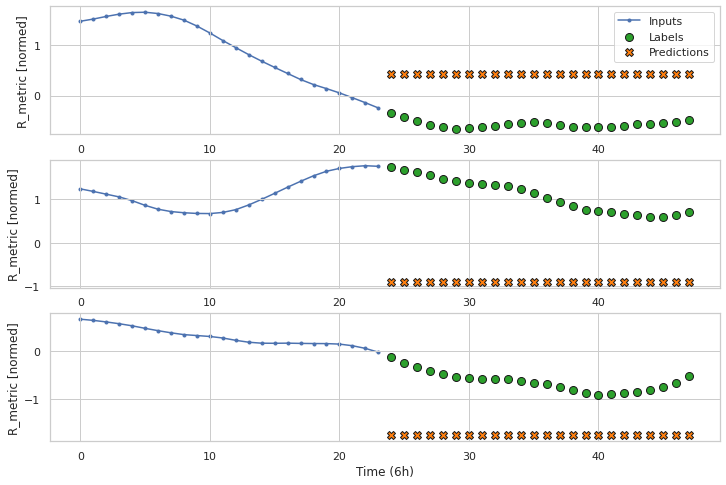

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)


## Single-shot model

Where model makes the entire prediction at once

## CNN


A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/structured_data/images/multistep_conv.png)

99/99 [==============================] - 0s 3ms/step - loss: 0.3568 - mean_absolute_error: 0.4382


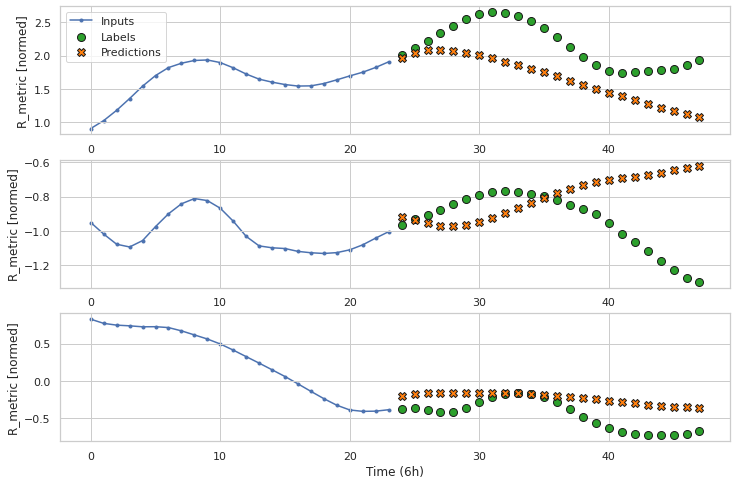

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)


## RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/structured_data/images/multistep_lstm.png)

99/99 [==============================] - 0s 4ms/step - loss: 0.4524 - mean_absolute_error: 0.4953


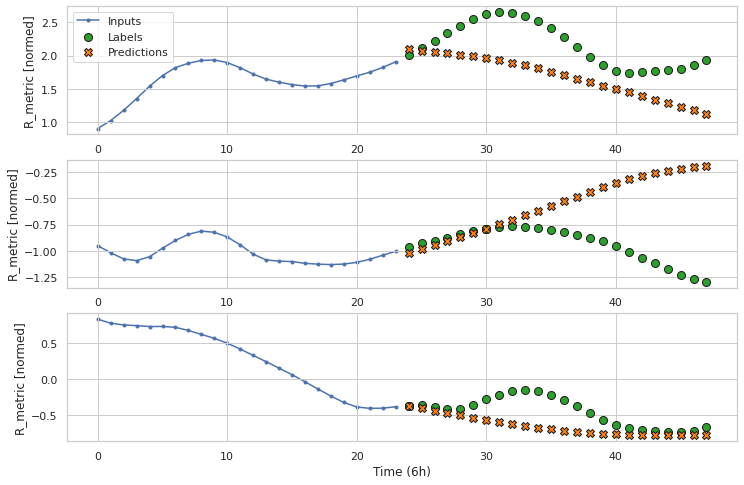

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## Advanced Autoregressive model

The above models all predict the entire output sequence as a in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of single single-step multi-output models trained in the first half of this tutorial and run  in an autoregressive feedback loop, but here we'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png)

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 10])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 10)


99/99 [==============================] - 1s 6ms/step - loss: 0.4570 - mean_absolute_error: 0.5138


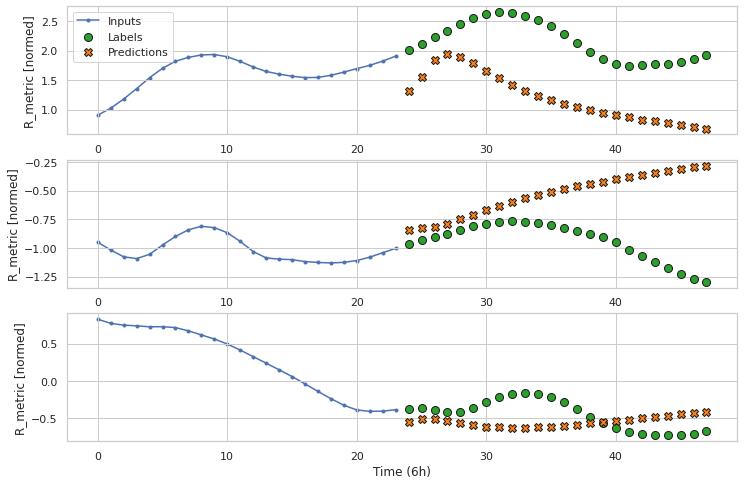

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

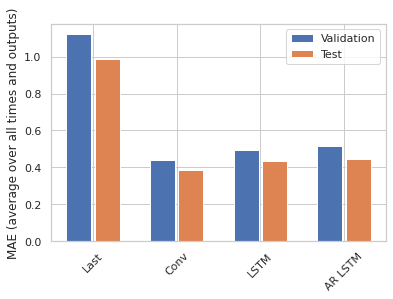

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()


**Increasing complexity produced diminishing results.**

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')


Last    : 0.9886
Conv    : 0.3863
LSTM    : 0.4375
AR LSTM : 0.4454


# Next Steps

Re-design the problem

*   Use ocean fingerprint, SST over Atlantic?
*   Increase input window for the model to figure out the function better?




